In [1]:
from tensorflow.keras.models import load_model
import pickle
from albumentations import ShiftScaleRotate,Cutout,RandomContrast,RandomBrightness,Compose
from utility.albumentations_helper import create_transform
from functions import generate_feature,loop_distance,dot_distance_neg_np,NW_PredictGenerator,l2_distance_np
import numpy as np
import pandas as pd
from functools import reduce,partial
import matplotlib.pyplot as plt

In [2]:
## change ##
color = False
FFA_size = 4
TTA_NW = 4
num_bins = 3
pct = 0.1
model_file = 'feature_model_DenseNet_Triplet2'
distanceFun = l2_distance_np

### Existing

In [3]:
feature_model = load_model('Models/'+model_file+'.h5')

In [4]:
feature_model.compile(loss='mse',optimizer='SGD')

In [5]:
#feature_model = load_model('Models/feature_l2_distance_margin_loss_fun_factory(0.1,5).h5', \
#                            custom_objects={'loss': margin_loss_fun_factory(0.1,5)})

In [6]:
with open('submit_train.pkl', 'rb') as f:
    submit_train = pickle.load(f)
with open('submit_test.pkl', 'rb') as f:
    submit_test = pickle.load(f)  
with open('submit_map.pkl', 'rb') as f:
    submit_map = pickle.load(f)        

In [7]:
aug = Compose([RandomContrast(p=0.2),RandomBrightness(p=0.2),
                ShiftScaleRotate(shift_limit=0.03,rotate_limit=15,scale_limit=0.02,p=1)])
transform = create_transform(aug)    

In [8]:
feature_train = generate_feature(submit_train,transform,FFA_size,color,feature_model)
feature_val = generate_feature(submit_test,transform,FFA_size,color,feature_model)
predicts = loop_distance(feature_train,feature_val,distanceFun,partial(np.quantile,q=pct,axis=(1,2)))

### New Whale

In [9]:
NW_model = load_model('Models/NewWhale.h5')

In [10]:
gen = NW_PredictGenerator(sum(submit_test,[]),transform)

In [11]:
p_NW_list = [NW_model.predict_generator(gen,workers=2,use_multiprocessing=True).flatten() for _ in range(TTA_NW)]

In [12]:
p_NW = np.sum(np.stack(p_NW_list,1),1)

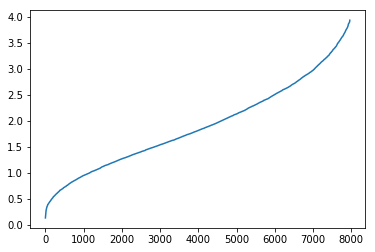

In [13]:
plt.plot(np.sort(p_NW))

### Combine New and Existing

In [14]:
tot_num = predicts.shape[0]
bins = np.quantile(p_NW,np.arange(num_bins+1)/num_bins)
bins[0] = -1
bins[-1] = 10
inds = num_bins - np.digitize(p_NW,bins)
print(np.unique(inds),np.bincount(inds))

[0 1 2] [2654 2653 2653]


In [15]:
predicts_nw = np.insert(predicts.flatten(),inds + np.arange(tot_num)*5,-1).reshape(tot_num,6)[:,:5]

Submit without New Whale Model

In [23]:
predicts = np.vectorize(submit_map.get)(predicts)

In [24]:
predicts=reduce(np.core.defchararray.add,['new_whale ',predicts[:,0],\
                                             ' ', predicts[:,1],\
                                             ' ', predicts[:,2],\
                                             ' ', predicts[:,3]])

In [25]:
submit_df = pd.DataFrame(list(zip([i[0].split('/')[-1].split('.')[0]+'.jpg' for i in submit_test],\
                          predicts.tolist())), columns=['Image','Id'])

In [26]:
submit_df.to_csv('submissions/'+model_file+'.csv',index=False)

Submit with New Whale Model

In [16]:
submit_map[-1] = 'new_whale'

In [17]:
predicts_nw = np.vectorize(submit_map.get)(predicts_nw)

In [18]:
predicts_nw=reduce(np.core.defchararray.add,[predicts_nw[:,0],\
                                             ' ', predicts_nw[:,1],\
                                             ' ', predicts_nw[:,2],\
                                             ' ', predicts_nw[:,3],\
                                             ' ', predicts_nw[:,4]])

In [19]:
submit_df = pd.DataFrame(list(zip([i[0].split('/')[-1].split('.')[0]+'.jpg' for i in submit_test],\
                          predicts_nw.tolist())), columns=['Image','Id'])

In [20]:
submit_df.to_csv('submissions/'+model_file+'_nw.csv',index=False)